2025-05-06 05:01:37.567101: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 05:01:37.588077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 05:01:37.588094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 05:01:37.588863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 05:01:37.592662: I tensorflow/core/platform/cpu_feature_guar

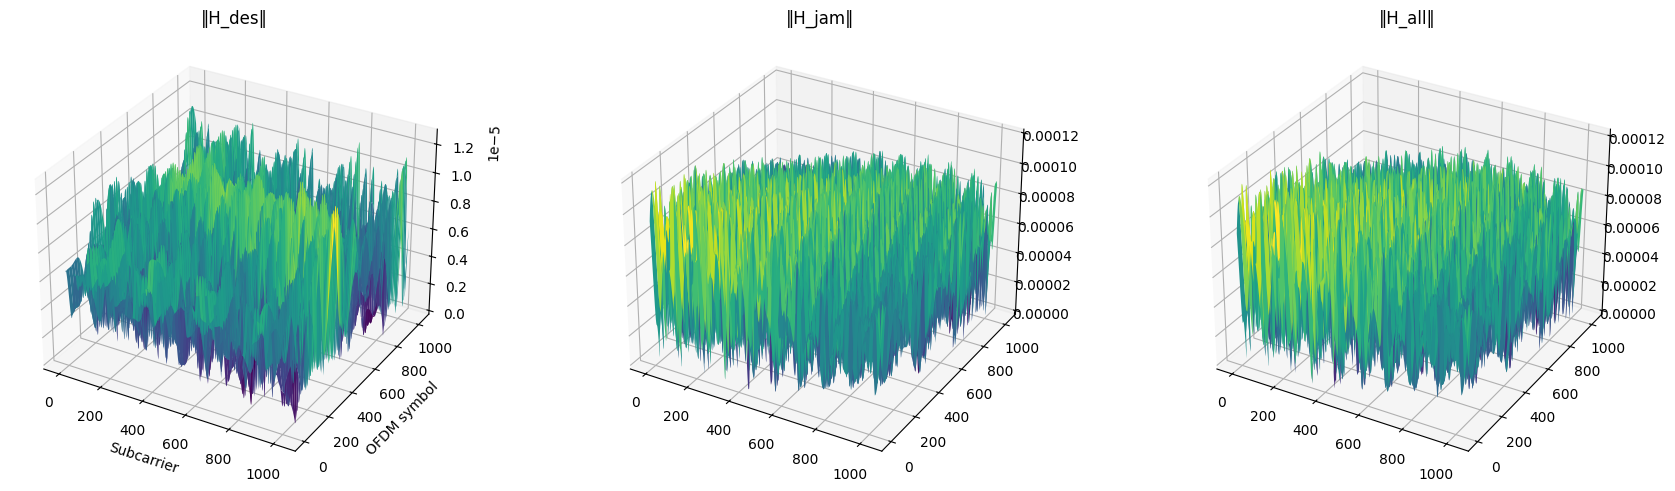

In [1]:
# %%
"""
Full-band CFR demo – Python 3.11 · TF 2.19 · Sionna 1.0.2
"""

# --------------------------------------------------------------------#
# 0) Imports & GPU housekeeping
# --------------------------------------------------------------------#
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import sionna, sionna.rt



gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, PathSolver, subcarrier_frequencies

# Other imports          
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import sys
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, watt_to_dbm

from sionna.phy.channel import OFDMChannel, CIRDataset
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector
from sionna.phy.mimo import StreamManagement

# Import Sionna RT components
from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver
import random


# %%
"""
Full-band CFR demo – Python 3.11 · TF 2.19 · Sionna 1.0.2
"""

# ── 參數區 ───────────────────────────────────────────────────────────────
# 場景與天線
# SCENE_NAME      = sionna.rt.scene.etoile
SCENE_NAME      = "GIS.xml"
TX_ARRAY_CONFIG = dict(num_rows=1, num_cols=1,
                       vertical_spacing=0.5, horizontal_spacing=0.5,
                       pattern="iso", polarization="V")
RX_ARRAY_CONFIG = TX_ARRAY_CONFIG

# 發射機設定： (name, position, orientation, role)

# (name, pos, ori, role, power_dbm)
TX_LIST = [
  ("tx0",  [-100,-100,20], [np.pi*5/6,0,0],     "desired", 30),
  ("tx1",  [-100,  50,20], [np.pi/6,  0,0],     "desired", 30),
  ("tx2",  [ 100,-100,20], [-np.pi/2,0,0],      "desired", 30),
  ("jam1", [ 100, 50, 20], [np.pi/2,  0,0],     "jammer",  40),
  ("jam2", [ 50,  50, 20], [np.pi/2,  0,0],     "jammer",  40),
  ("jam3", [ -50, -50,20], [np.pi/2,  0,0],     "jammer",  40), 
]


RX_CONFIG      = ("rx", [0,0,20])  # (name, position)

# PathSolver 參數
PATHSOLVER_ARGS = dict(max_depth=10,
                       los=True,
                       specular_reflection=True,
                       diffuse_reflection=False,
                       refraction=False,
                       synthetic_array=False,
                       seed=41)

# RadioMapSolver 參數
RMSOLVER_ARGS   = dict(max_depth=10,
                       cell_size=(1.,1.),
                       samples_per_tx=10**7)

# OFDM / QPSK 參數
N_SYMBOLS       = 1
N_SUBCARRIERS   = 1024
SUBCARRIER_SPACING = 30e3  # Hz
num_ofdm_symbols = 1024 
num_subcarriers = 1024
subcarrier_spacing = 30e3

# 通道品質參數
JNR_dB          = 5.0
EBN0_dB         = 20.0

# 繪圖範圍（SINR dB）
SINR_VMIN       = -40
SINR_VMAX       =   0


# %%

# ── 程式區 ───────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sionna, sionna.rt
from sionna.rt import (load_scene, PlanarArray, Transmitter, Receiver,
                       PathSolver, RadioMapSolver, subcarrier_frequencies)

# GPU 設定
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
gpus = tf.config.list_physical_devices("GPU")
if gpus: tf.config.experimental.set_memory_growth(gpus[0], True)

# 1) 建立場景與天線配置
scene = load_scene(SCENE_NAME)
scene.tx_array = PlanarArray(**TX_ARRAY_CONFIG)
scene.rx_array = PlanarArray(**RX_ARRAY_CONFIG)
for tx_name in scene.transmitters.copy():  
    scene.remove(tx_name)
# 再把所有 receiver name 拿出來，一個個 remove
for rx_name in scene.receivers.copy():
    scene.remove(rx_name)

# 確認都清空了
assert len(scene.transmitters)==0 and len(scene.receivers)==0

# 2) 新增 Tx (含 role 標籤)
def add_tx(scene, name, pos, ori, role, power_dbm):
    tx = Transmitter(name=name, position=pos,
                      power_dbm=power_dbm)
    tx.role = role
    scene.add(tx)
    return tx

# 迴圈時 unpack 五個欄位
for name, pos, ori, role, p_dbm in TX_LIST:
    add_tx(scene, name, pos, ori, role, p_dbm)


# 3) 新增 Rx
rx_name, rx_pos = RX_CONFIG
rx = Receiver(name=rx_name, position=rx_pos)
scene.add(rx)

# 4) 自動分組 indices
tx_names = scene.transmitters
all_txs   = [scene.get(n) for n in tx_names]
idx_des   = [i for i,tx in enumerate(all_txs) if getattr(tx,'role',None)=='desired']
idx_jam   = [i for i,tx in enumerate(all_txs) if getattr(tx,'role',None)=='jammer']

# 5) RadioMap 計算
rm_solver = RadioMapSolver()
rm = rm_solver(scene, **RMSOLVER_ARGS)

# 6) PathSolver 函式
solver = PathSolver()
def solve():
    return solver(scene, **PATHSOLVER_ARGS)

# 7) 計算 CFR
freqs = subcarrier_frequencies(N_SUBCARRIERS, SUBCARRIER_SPACING)
for name in scene.transmitters:
    scene.get(name).velocity = [30, 0, 0]   # 或者 jam1 用 [-30,0,0]
paths = solve()

def dbm2w(dbm):
    return 10**(dbm/10) / 1000

tx_powers = [ dbm2w(scene.get(n).power_dbm) 
              for n in scene.transmitters ]

ofdm_symbol_duration = 1/subcarrier_spacing
delay_resolution = ofdm_symbol_duration/num_subcarriers
doppler_resolution = subcarrier_spacing/num_ofdm_symbols

H_unit = paths.cfr(
    frequencies         = freqs,
    sampling_frequency  = 1/ofdm_symbol_duration,
    num_time_steps      = num_ofdm_symbols,   # ← 讓 Sionna 跑時間演變 (多普勒)
    normalize_delays    = True,
    normalize           = False,
    out_type            = "numpy"
    ).squeeze()           # shape: (num_tx, T, F)

H_all = np.sqrt(np.array(tx_powers)[:,None,None]) * H_unit

H_des = H_all[idx_des].sum(axis=0)   # (T, F)
H_jam = H_all[idx_jam].sum(axis=0)   # (T, F)
H = H_unit[:,0,:]

def gray_64qam_mapper(b):          # b: (..., 6) bits
    """
    回傳複數 constellation，平均功率 = 1
    Gray mapping: [b0…b5] = [msb … lsb]
    I = 8-PAM(b0 b2 b4), Q = 8-PAM(b1 b3 b5)
    """
    b = np.asarray(b, dtype=int)
    assert b.shape[-1] == 6
    # split bits
    b0,b1,b2,b3,b4,b5 = [b[...,i] for i in range(6)]
    # Gray → 3‐bit binary
    def gray3_to_level(g2,g1,g0):
        # g2 g1 g0 = Gray bits, 得到 0…7
        bin2 = g2
        bin1 = g1 ^ bin2
        bin0 = g0 ^ bin1
        val  = bin2*4 + bin1*2 + bin0
        return val
    I_idx = gray3_to_level(b0,b2,b4)
    Q_idx = gray3_to_level(b1,b3,b5)
    # 8-PAM levels: {-7,-5,-3,-1,+1,+3,+5,+7}
    pam = np.array([-7,-5,-3,-1,+1,+3,+5,+7])
    I = pam[I_idx]
    Q = pam[Q_idx]
    s = I + 1j*Q
    # Normalize to unit average power
    s = s / np.sqrt((42))       # E{|s|^2}=42 ⇒ 除√42≈6.4807
    return s

h_main = sum( np.sqrt(tx_powers[i]) * H[i] 
                for i in idx_des )
h_intf = sum( np.sqrt(tx_powers[i]) * H[i] 
                for i in idx_jam )

# # 8) 產生 QPSK+OFDM 符號
bits       = np.random.randint(0,2,(N_SYMBOLS, N_SUBCARRIERS, 2))
bits_jam       = np.random.randint(0,2,(N_SYMBOLS, N_SUBCARRIERS, 2))
X_sig     = (1-2*bits[...,0] + 1j*(1-2*bits[...,1]))/np.sqrt(2)
X_jam     = (1-2*bits_jam[...,0] + 1j*(1-2*bits_jam[...,1]))/np.sqrt(2)

Y_sig  = X_sig * h_main[None,:]         # 跟舊程式同
Y_int  = X_jam * h_intf[None,:]         # ……
p_sig      = np.mean(np.abs(Y_sig)**2)
p_int      = np.mean(np.abs(Y_int)**2)
N0         = p_sig/(10**(EBN0_dB/10)*2)
noise      = np.sqrt(N0/2)*(np.random.randn(*Y_sig.shape)+1j*np.random.randn(*Y_sig.shape))
Y_tot      = Y_sig + Y_int + noise
y_eq_no_i  = (Y_sig + noise)   / h_main
y_eq_with_i= (Y_sig + Y_int + noise) / h_main

# %%
H_unit = paths.cfr(
    frequencies         = freqs,
    sampling_frequency  = 1/ofdm_symbol_duration,
    num_time_steps      = num_ofdm_symbols,   # ← 讓 Sionna 跑時間演變 (多普勒)
    normalize_delays    = True,
    normalize           = False,
    out_type            = "numpy"
    ).squeeze()           # shape: (num_tx, T, F)
# 11) 計算 Delay-Doppler圖
H_all = H_unit.sum(axis=0)
H_des = H_unit[idx_des].sum(axis=0)   # (T, F)
H_jam = H_unit[idx_jam].sum(axis=0)   # (T, F)


def to_delay_doppler(H_tf):
    Hf      = np.fft.fftshift(H_tf, axes=1)            # F shift
    h_delay = np.fft.ifft(Hf, axis=1 , norm="ortho")   # F→delay
    h_dd    = np.fft.fft(h_delay, axis=0 , norm="ortho")# t→doppler
    h_dd    = np.fft.fftshift(h_dd, axes=0)            # doppler shift
    return h_dd

Hdd_all = to_delay_doppler(H_all)
Hdd_des = to_delay_doppler(H_des)
Hdd_jam = to_delay_doppler(H_jam)
T, F = Hdd_des.shape                # =1024,1024
offset = 20

# Delay：真正有多徑的前 40 bins
d_start, d_end = 0, offset*2        # [0:40]

# Doppler：fftshift 之後的 0 Hz 在 row=T//2
t_mid = T//2                        # 512
t_start, t_end = t_mid-offset, t_mid+offset  # [492:532]

# 座標軸
delay_bins   = np.arange(F) * ((1/subcarrier_spacing)/F)*1e9  # ns
doppler_bins = np.fft.fftshift(np.fft.fftfreq(T, d=1/subcarrier_spacing))

X, Y = np.meshgrid(delay_bins[d_start:d_end],
                   doppler_bins[t_start:t_end])

Z_des = np.abs(Hdd_des[t_start:t_end, d_start:d_end])
Z_jam = np.abs(Hdd_jam[t_start:t_end, d_start:d_end])
Z_all = np.abs(Hdd_all[t_start:t_end, d_start:d_end])

# %%
H_unit = paths.cfr(
    frequencies         = freqs,
    sampling_frequency  = 1/ofdm_symbol_duration,
    num_time_steps      = num_ofdm_symbols,   # ← 讓 Sionna 跑時間演變 (多普勒)
    normalize_delays    = True,
    normalize           = False,
    out_type            = "numpy"
    )           # shape: (num_tx, T, F)
########################################
# 1) 線性功率 (W)──長度 = Tx_num = 6
########################################
tx_p_lin = 10**(np.array([tx.power_dbm for tx in all_txs]) / 10) / 1e3   # (6,)
tx_p_lin = np.squeeze(tx_p_lin)   # (6,)

########################################
# 2) 把 sqrt(P) 乘到 Tx_num 那一軸 (axis=2)
########################################
# H_unit : (1,1,6,1,1024,1024)
sqrtP    = np.sqrt(tx_p_lin)[None, None, :, None, None, None]            # (1,1,6,1,1,1)
H_pw     = H_unit * sqrtP                                                # 廣播後同 shape
########################################
# 3) 先依「Tx 角色」選出 desired / jammer
########################################
H_pw_des = H_pw[:,:,idx_des,:,:,:]     # 仍是 (1,1,len_des,1,T,F)
H_pw_jam = H_pw[:,:,idx_jam,:,:,:]
H_pw_des = np.squeeze(H_pw_des)   # (1,1,len_des,1,T,F)
H_pw_jam = np.squeeze(H_pw_jam)   # (1,1,len_jam,1,T,F)

########################################
# 4) 把 Rx_num、Rx_ant、Tx_num、Tx_ant 四軸全部加總 → (T,F)
########################################
# axis=(0,1,2,3) 對應上面四個天線相關維度
H_des = np.sum(H_pw_des, axis=(0))      # (1024,1024)
H_jam = np.sum(H_pw_jam, axis=(0))      # (1024,1024)
H_all = H_des + H_jam

########################################
# 5) Delay–Doppler  (現在 H_des 已是 (T,F))
########################################
def to_delay_doppler(H_tf):
    Hf      = np.fft.fftshift(H_tf, axes=1)            # F shift
    h_delay = np.fft.ifft(Hf, axis=1 , norm="ortho")   # F→delay
    h_dd    = np.fft.fft(h_delay, axis=0 , norm="ortho")# t→doppler
    h_dd    = np.fft.fftshift(h_dd, axes=0)            # doppler shift
    return h_dd

Hdd_des = to_delay_doppler(H_des)    # (T,F)
Hdd_jam = to_delay_doppler(H_jam)
Hdd_all = to_delay_doppler(H_all)

T, F = Hdd_des.shape                # =1024,1024
offset = 20

# Delay：真正有多徑的前 40 bins
d_start, d_end = 0, offset*2        # [0:40]

# Doppler：fftshift 之後的 0 Hz 在 row=T//2
t_mid = T//2                        # 512
t_start, t_end = t_mid-offset, t_mid+offset  # [492:532]

# 座標軸
delay_bins   = np.arange(F) * ((1/subcarrier_spacing)/F)*1e9  # ns
doppler_bins = np.fft.fftshift(np.fft.fftfreq(T, d=1/subcarrier_spacing))

X, Y = np.meshgrid(delay_bins[d_start:d_end],
                   doppler_bins[t_start:t_end])

Z_des = np.abs(Hdd_des[t_start:t_end, d_start:d_end])
Z_jam = np.abs(Hdd_jam[t_start:t_end, d_start:d_end])
Z_all = np.abs(Hdd_all[t_start:t_end, d_start:d_end])


# %%
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (只為觸發 3D)

T, F = H_des.shape
t_axis = np.arange(T)              # 0,1,…,T-1  (OFDM symbol index)
f_axis = np.arange(F)              # 0,1,…,F-1  (Subcarrier index)
T_mesh, F_mesh = np.meshgrid(t_axis, f_axis, indexing='ij')

fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(F_mesh, T_mesh, np.abs(H_des),
                 cmap='viridis', edgecolor='none')
ax1.set_xlabel("Subcarrier"); ax1.set_ylabel("OFDM symbol")
ax1.set_title("‖H_des‖")

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(F_mesh, T_mesh, np.abs(H_jam),
                 cmap='viridis', edgecolor='none')
ax2.set_title("‖H_jam‖")

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(F_mesh, T_mesh, np.abs(H_all),
                 cmap='viridis', edgecolor='none')
ax3.set_title("‖H_all‖")

plt.tight_layout(); plt.show()